# Introduction

In this notebook, we evaluate the model pretrained on the **Inria Aerial Image Labeling** dataset from `00b_inria_prepare_data.ipynb` and use it to inspect possible additional mislabels of the MapAI data set. 

# Setup

In [1]:
from datetime import date

In [2]:
from fastai.vision.all import *
from fastai_metrics import * 
from loss_functions import CombinedCEFocalTverskyLoss

In [3]:
#torch.cuda.set_device(1)

In [4]:
from constants import DATADIR, INRIA_DATA, INRIA_PATCHES, INRIA_PREDS

In [5]:
INRIA_PREDS.mkdir(exist_ok=True)

(INRIA_PREDS/'val').mkdir(exist_ok=True)

# Load data

We load the INRIA dataset prepared by the notebook `00b_inria_prepare_data.ipynb` and used in nb `02a`:

In [6]:
df = pd.read_csv('../csv/inria_aerial_image_dataset_train-2022-11-18.csv')
df.shape

(18000, 4)

In [23]:
def update_p(p):
    return str(p).replace('ubuntu', 'alex')

In [24]:
df['image'] = df['image'].apply(update_p)
df['mask'] = df['mask'].apply(update_p)

In [25]:
df.head()

,image,mask,is_val,location
0,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_01.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_01.png,False,austin10
1,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_02.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_02.png,False,austin10
2,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_03.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_03.png,False,austin10
3,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_04.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_04.png,False,austin10
4,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_05.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_05.png,False,austin10


In [26]:
val_locs = ['austin1', 'kitsap16', 'tyrol-w5', 'vienna4']

In [27]:
df.loc[df.location.isin(val_locs), 'is_val'] = True

In [28]:
df.is_val.value_counts()

False    17600
True       400
Name: is_val, dtype: int64

# Recreate dataloaders

In [29]:
models = [resnet34, resnet50, xresnet34, xresnet50]
model_idx = 0

In [30]:
model_name = str(models[model_idx]).split(' ')[1]
model_name

'resnet34'

In [31]:
if '50' in model_name:
    bs = 32
else:
    bs = 64

In [32]:
codes = [0,1]

In [33]:
sz = (500,500)
half = tuple(int(x/2) for x in sz)

In [34]:
from training import get_batch_tfms, get_dataloaders, BinaryConverter

In [35]:
item_tfms=[BinaryConverter()]

In [36]:
batch_tfms = get_batch_tfms(normalize=Normalize.from_stats(*imagenet_stats), size=None)

In [37]:
dls = get_dataloaders(df, x_name='image', y_name='mask', codes=codes, 
                      splitter=ColSplitter('is_val'), 
                      bs=bs, item_tfms=item_tfms, 
                      batch_tfms=batch_tfms)

# Load trained model

In [39]:
#opt = ranger

In [40]:
metrics = [Dice, iou] #biou

In [41]:
from loss_functions import CombinedFocalTanimotoLoss
loss_func = CombinedFocalTanimotoLoss()

In [44]:
learn = unet_learner(dls, models[model_idx], loss_func=loss_func, metrics=metrics, 
                     self_attention=True).to_fp16()

/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
save_fn = f'stage-4_resnet34_pretraining-2022-12-01-focaltanimoto-final'

In [46]:
learn.load(save_fn);

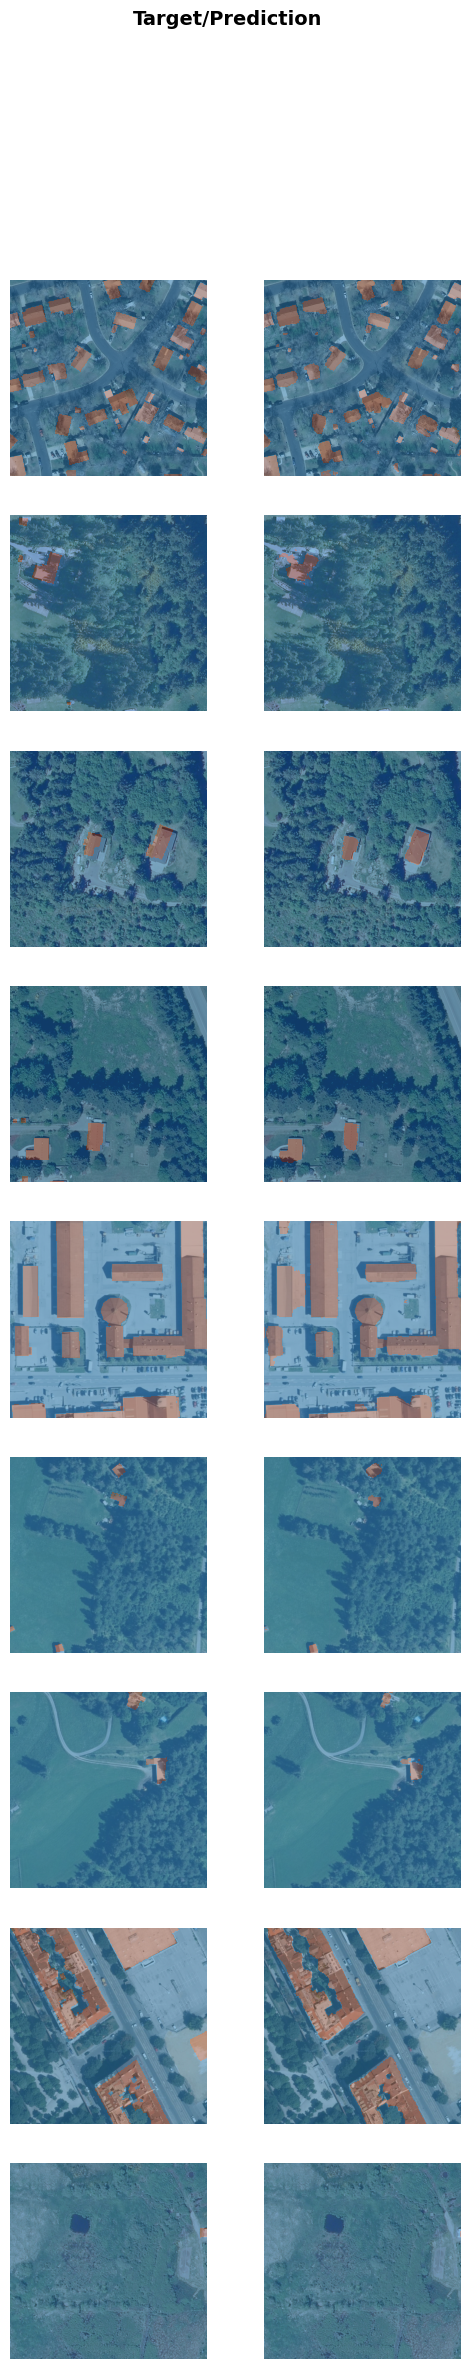

In [47]:
learn.show_results()

# Evaluate

In [48]:
val_pred_df = learn.dls.valid_ds.items

In [49]:
train_pred_df = learn.dls.train_ds.items

In [50]:
train_pred_df.head()

,image,mask,is_val,location
0,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_01.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_01.png,False,austin10
1,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_02.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_02.png,False,austin10
2,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_03.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_03.png,False,austin10
3,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_04.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_04.png,False,austin10
4,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_05.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_05.png,False,austin10


In [51]:
val_pred_df.head()

,image,mask,is_val,location
1000,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_01.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_01.png,True,austin1
1001,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_02.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_02.png,True,austin1
1002,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_03.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_03.png,True,austin1
1003,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_04.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_04.png,True,austin1
1004,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_05.png,/home/alex/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_05.png,True,austin1


In [52]:
val_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1000 to 17499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     400 non-null    object
 1   mask      400 non-null    object
 2   is_val    400 non-null    bool  
 3   location  400 non-null    object
dtypes: bool(1), object(3)
memory usage: 12.9+ KB


In [53]:
val_inputs, val_preds, val_targets, val_decoded_preds = learn.get_preds(with_input=True, with_decoded=True)

0: input image

1: output probs

2: ground truth

3: decoded predictions

In [54]:
from utils import compute_dice

In [55]:
def inspect_pred(i):
    fn = val_pred_df.iloc[i].image
    
    orig_image = load_image(fn)
    
    inp = val_inputs[i]
    pred = val_preds[i]
    targ = val_targets[i]
    decoded_pred = val_decoded_preds[i]
    
    dice = compute_dice(targ, decoded_pred)
    
    f, axs = plt.subplots(2,3,figsize=(8,8))
    plt.suptitle(f"Results for image {i}. Dice: {np.round(dice,4)}")
    show_image(orig_image, ax=axs[0][0])
    axs[0][0].set_title(f"Original image")
    inp.show(ax=axs[0][1])
    axs[0][1].set_title(f"Input image")
    axs[0][2].imshow(pred[1,::])
    axs[0][2].set_title(f"Prediction")
    axs[1][0].imshow(targ)
    axs[1][0].set_title(f"GT mask")
    axs[1][1].imshow(decoded_pred)
    axs[1][1].set_title(f"Decoded prediction")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


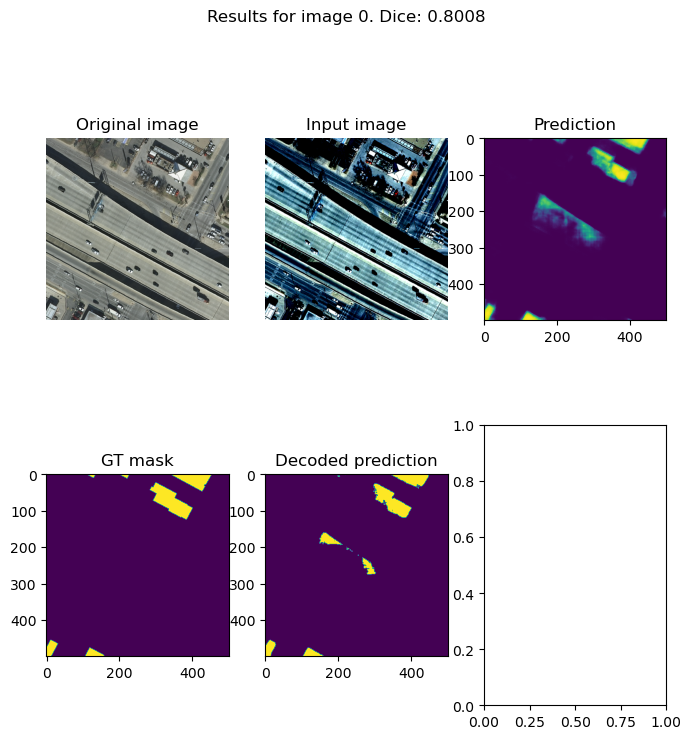

In [56]:
inspect_pred(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


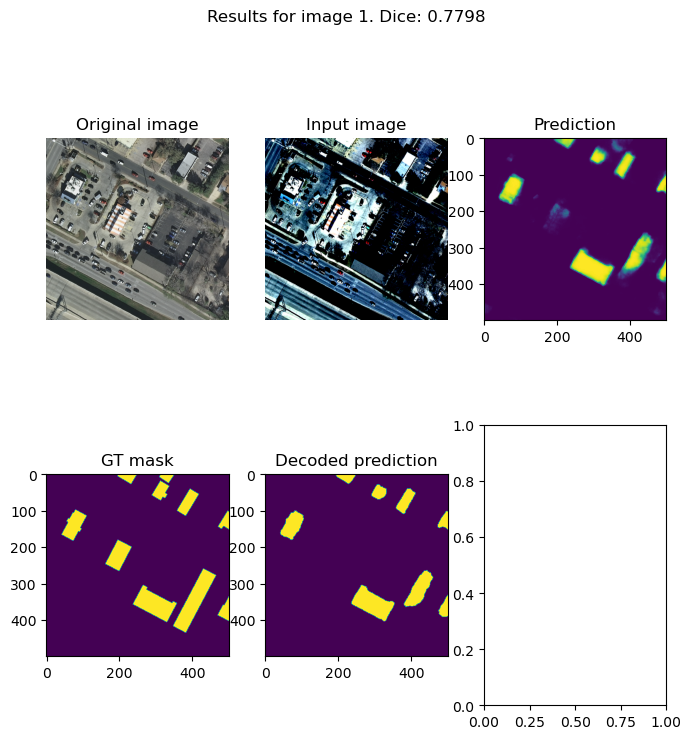

In [57]:
inspect_pred(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


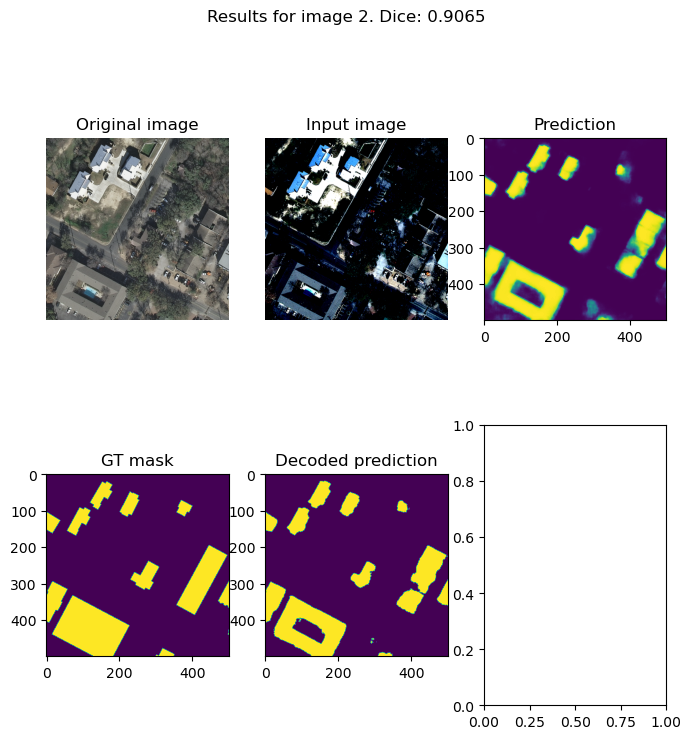

In [58]:
inspect_pred(2)

### Predictions on single images

In [59]:
def get_pred(df, idx, dice=False, show=True, savedir=None):
    
    img_path = df.iloc[idx]['image']
    mask_path = df.iloc[idx]['mask']
    
    img_fn = Path(img_path).stem

    
    img = PILImage.create(img_path)
    mask = TensorMask(PILImage.create(mask_path))[:,:,0]
    
    pred,_,probs = learn.predict(img) #TTA?
    
    if dice:
        print(f"DICE: {compute_dice(mask, pred)}")
    
    if show:
        f, axs = plt.subplots(2,3, figsize=(8,10))
        axs[0][0].imshow(img)
        axs[0][0].set_title(f"Original image")
        
        axs[0][1].imshow(np.array(pred))
        axs[0][1].set_title(f"Predicted mask")
        
        axs[0][2].imshow(mask)
        axs[0][2].set_title(f"GT mask")
        
        axs[1][0].imshow(img)
        axs[1][0].imshow(pred, alpha=0.4)
        axs[1][0].set_title(f"Prediction overlayed")
        
        axs[1][1].imshow(img)
        axs[1][1].imshow(mask, alpha=0.4)
        axs[1][1].set_title(f"GT overlayed")
        plt.show()
        
    if savedir:
        pred_img = Image.fromarray(((pred.numpy()*255).astype('uint8')))
        pred_img.save(savedir/f'{img_fn}-mask.png')
        
    return pred

In [60]:
# Save all masks
#for i in range(len(val_pred_df)):
#    _ = get_pred(val_pred_df, i, show=False, savedir=INRIA_PREDS/'val')

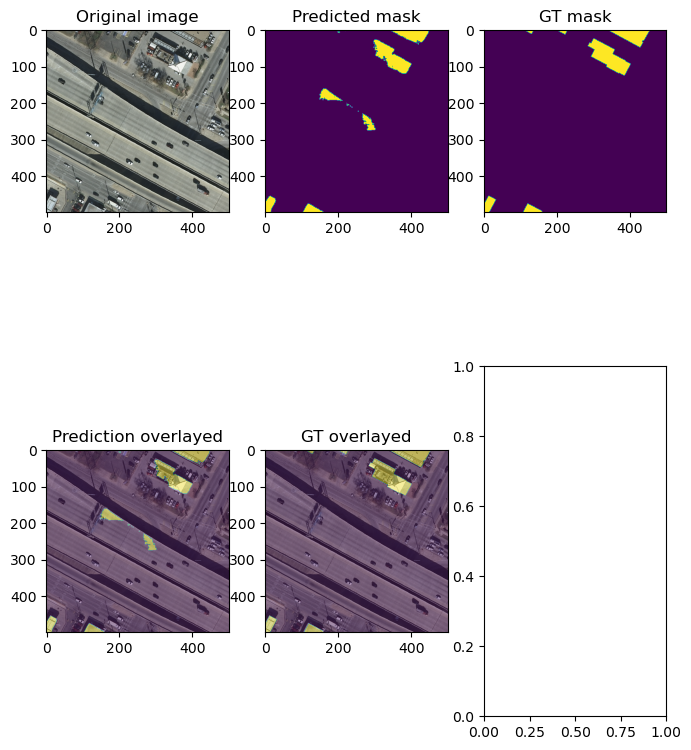

In [61]:
_ = get_pred(val_pred_df, 0, show=True, dice=False, savedir=None)

## Insert in dataframe

In [42]:
val_df = df.loc[df.is_val]

In [43]:
val_df.head()

,image,mask,is_val,location
1000,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_01.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_01.png,True,austin1
1001,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_02.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_02.png,True,austin1
1002,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_03.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_03.png,True,austin1
1003,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_04.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_04.png,True,austin1
1004,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_05.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_05.png,True,austin1


In [70]:
def get_predicted_png(fn):
    fn = Path(fn)
    folder = fn.parent
    png = fn.stem
    out_folder = Path(str(folder).replace("images", "predictions/val"))
    out_fn = f"{png}-mask.png"
    out_path = out_folder/out_fn
    return out_path

In [71]:
val_df.insert(4, column='prediction', value=val_df['image'].apply(get_predicted_png))

In [72]:
val_df.head()

,image,mask,is_val,location,prediction
1000,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_01.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_01.png,True,austin1,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_01-mask.png
1001,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_02.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_02.png,True,austin1,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_02-mask.png
1002,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_03.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_03.png,True,austin1,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_03-mask.png
1003,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_04.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_04.png,True,austin1,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_04-mask.png
1004,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_05.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin1_01_05.png,True,austin1,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_05-mask.png


In [73]:
val_df.to_csv('inria_val_data_with_preds.csv', index=None)

# Stitch predictions back together

In [44]:
from utils import get_concat

In [42]:
val_df = pd.read_csv('inria_val_data_with_preds.csv')

In [43]:
austin1_df = val_df.loc[val_df.location=='austin1']

In [44]:
len(austin1_df)

100

In [98]:
images_df = pd.DataFrame(austin1_df.image.values.reshape(10,10))
images_df.head()

,0,1,2,3,4,5,6,7,8,9
0,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_01.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_02.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_03.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_04.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_05.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_06.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_07.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_08.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_09.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_01_10.png
1,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_01.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_02.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_03.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_04.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_05.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_06.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_07.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_08.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_09.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_02_10.png
2,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_01.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_02.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_03.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_04.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_05.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_06.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_07.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_08.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_09.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_03_10.png
3,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_04_01.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_04_02.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_04_03.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_04_04.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin1_04_05.png,/home/ubuntu/dat

In [99]:
predictions_df = pd.DataFrame(austin1_df.prediction.values.reshape(10,10))
predictions_df.head()

,0,1,2,3,4,5,6,7,8,9
0,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_01-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_02-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_03-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_04-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_05-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_06-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_07-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_08-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_09-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_01_10-mask.png
1,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_01-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_02-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_03-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_04-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_05-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_06-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_07-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_08-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_09-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_02_10-mask.png
2,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_01-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_02-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_03-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_04-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_05-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_06-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_07-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_08-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_09-mask.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_03_10-mask.png
3,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/predictions/val/austin1_04_01-mask.png,/home/ubuntu/data/mapai/external/i

In [108]:
get_concat(images_df, 'austin1.jpg')

10 10


In [109]:
get_concat(predictions_df, 'austin1_pred.jpg')

10 10


In [110]:
def create_animation(location):
    # Create stitched-together original image
    images_df = pd.DataFrame(val_df.loc[val_df.location==location].image.values.reshape(10,10))
    get_concat(images_df, f'{location}.png')
    
    
    # Create stitched predicted masks:
    prediction_df = pd.DataFrame(val_df.loc[val_df.location==location].prediction.values.reshape(10,10))
    get_concat(prediction_df, f'{location}-predicted_mask.png')
    
    
    # Create multiple images with mask pasted in
    
    new_df = images_df.copy()
    for i in range(100):
        img_to_replace = images_df.to_numpy().flatten()[i]
        mask_to_insert = img_to_replace.replace(".png", "-mask.png").replace('images','predictions').replace('predictions', 'predictions/val')
        new_df = new_df.replace(img_to_replace,mask_to_insert)
        i+1
        get_concat(new_df, f'{location}_pred_{i}.jpg')
        
    # Create GIF animation
    fn_pattern = f'{location}_pred_*.jpg'
    gif_fn = f'{location}_preds.gif'
    !convert -resize 800x800 -delay 20 -loop 0 `ls -v1 $fn_pattern` $gif_fn

In [111]:
create_animation('austin1')

10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10


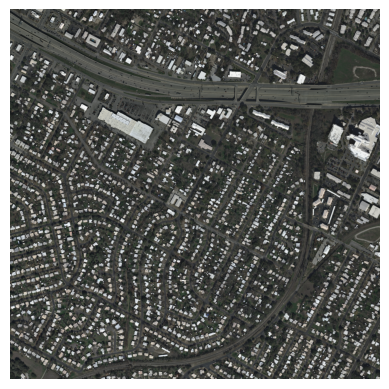

In [46]:
plt.imshow(Image.open('austin1.png'))
plt.imshow(np.array(Image.open('austin1_pred.png'))*255, alpha=0.4)
plt.axis('off')
plt.savefig('austin1_overlay.png')

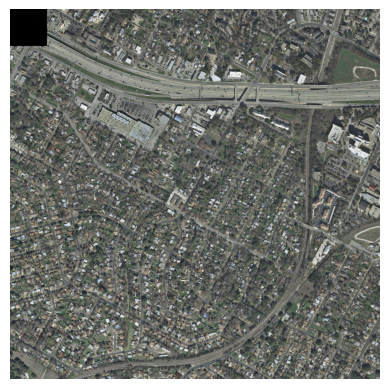

In [47]:
plt.imshow(np.array(Image.open('austin1_pred_0.png')))
plt.axis('off')
plt.show()
#plt.savefig('austin1_overlay.png')